試用現有資料 和SIRD模型 
找出不隨時間變化的參數 
感染率beta 
復原率 gamma
死亡率 mu

In [1]:
import requests
import pandas as pd
import torch.optim as optim
import numpy as np

#收集從1月27日到九月中的資料
DATA=[]


將每個月分的資料以月為單位讀入

In [2]:
for i in range(27,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [3]:
for i in range(1,30):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/02-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [4]:
for i in range(1,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [5]:
for i in range(1,31):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [6]:
for i in range(1,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [7]:
for i in range(1,31):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [8]:
for i in range(1,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [9]:
for i in range(1,32):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/08-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

In [10]:
for i in range(1,14):
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/09-'+str(i)+'-2020.csv'
  res = requests.get(url, allow_redirects=True)
  with open('covid.csv','wb') as file:
     file.write(res.content)
  DATA.append(pd.read_csv('covid.csv'))

取出特定國家的資料

In [159]:
Data_Germany=[]
for i in range(len(DATA)):
  if 'Country/Region' in DATA[i] :
    fliter = (DATA[i]['Country/Region']=='Germany')
    if len(DATA[i][fliter])>0:
      Data_Germany.append(DATA[i][fliter])
  elif 'Country_Region' in DATA[i] :
    fliter = (DATA[i]['Country_Region']=='Germany')
    if len(DATA[i][fliter])>0:
      Data_Germany.append(DATA[i][fliter])

取得每天的 S(疑似) I(感染) R(復原) D(死亡) 資料

In [359]:
def take_SIRD_data(Data):
  St=[]
  for i in range(len(Data_Germany)):
    St.append(Data_Germany[i]['Confirmed'].sum())
  St=np.array(St)
  It=[]
  for i in range(len(Data_Germany)):
    It.append(Data_Germany[i]['Confirmed'].sum()-Data_Germany[i]['Deaths'].sum()-Data_Germany[i]['Recovered'].sum())
  It=np.array(It)
  Rt=[]
  for i in range(len(Data_Germany)):
    Rt.append(Data_Germany[i]['Recovered'].sum())
  Rt=np.array(Rt)
  Dt=[]
  for i in range(len(Data_Germany)):
    Dt.append(Data_Germany[i]['Deaths'].sum())
  Dt=np.array(Dt)

  return St,It,Rt,Dt

In [368]:
[St,It,Rt,Dt]=take_SIRD_data(Data_Germany)

In [339]:
#國家人口數據 論文內有附上
population_N=83.02*1000000
St=St[0:3]
It=It[0:3]
Rt=Rt[0:3]
Dt=Dt[0:3]

In [340]:
import numpy as np
from scipy.optimize import minimize

def objective(x):

  #參數 dt 單位天數
  dt=1
  beta=x[0]
  gamma=x[1]
  mu=x[2]
  
  #藉由finite difference method 做出下一個時間點的預測

  St_pred=St*(1-dt*beta*It/population_N)
  It_pred=It*(1+dt*(beta*St/population_N)-dt*(mu+gamma))
  Rt_pred=Rt+(dt*gamma*It)
  Dt_pred=Dt+(dt*mu*It)
  
  # loss function 只取用論文中使用的loss function的前兩項
  loss=0.01*np.log(np.max(It))/np.max(It)*((It[1:len(It)]-It_pred[0:len(It_pred)-1])**2).sum()+((np.log(It[1:len(It)]+0.0000001)-np.log(It_pred[0:len(It_pred)-1]+0.000001))**2).sum()+0.01*np.log(np.max(It))/np.max(It)*((Dt[1:len(Dt)]-Dt_pred[0:len(Dt_pred)-1])**2).sum()+((np.log(Dt[1:len(Dt)]+0.0000001)-np.log(Dt_pred[0:len(Dt_pred)-1]+0.0000001))**2).sum()                                                                                                                   
  return loss


In [341]:

# initial guesses
beta = 0.5
gamma = 0.5
mu = 0.5
population_N
n = 3
x0 = np.zeros(n)
x0[0] = beta
x0[1] = gamma
x0[2] = mu
b = (0.0,1.0)
bnds = (b, b, b)

In [342]:
Sol=minimize(objective,x0,bounds=bnds)#,bounds=bnds

In [343]:
Sol

      fun: 1.5670403252685879e-12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.41895278e-13,  3.65244329e-06,  2.26427132e+07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 140
      nit: 21
   status: 0
  success: True
        x: array([1.00000000e+00, 1.12149645e-06, 0.00000000e+00])

In [344]:
objective(Sol.x)

1.5670403252685879e-12

In [345]:
beta=Sol.x[0]
gamma=Sol.x[1]
mu=Sol.x[2]
dt=1

St_pred=St*(1-dt*beta*It/population_N)

It_pred=It*(1+dt*(beta*St/population_N)-(mu+gamma))

Rt_pred=Rt+(dt*gamma*It)

Dt_pred=Dt+(dt*mu*It)


In [354]:
St_pred=St*(1-dt*beta*It/population_N)

It_pred=It*(1+dt*(beta*St/population_N)-(mu+gamma))

Rt_pred=Rt+(dt*gamma*It)

Dt_pred=Dt+(dt*mu*It)

[beta, gamma ,mu]

[1.0, 1.1214964487927055e-06, 0.0]

Text(0.5, 1.0, 'Death')

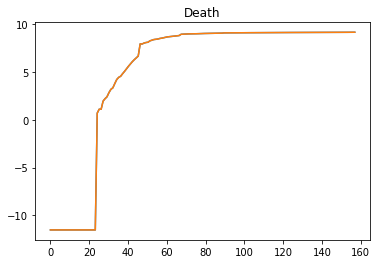

In [355]:
import matplotlib.pyplot as plt
dat=np.linspace(0,len(Dt)-1,len(Dt)-1)
plt.plot(dat,np.log(Dt_pred[0:len(Dt_pred)-1]+0.00001))
plt.plot(dat,np.log(Dt[0:len(Dt)-1]+0.00001))
plt.title('Death')

Text(0.5, 1.0, 'I')

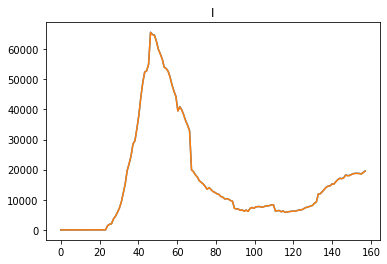

In [356]:
dat=np.linspace(0,len(It_pred)-1,len(It_pred)-1)
plt.plot(dat,It_pred[0:len(It_pred)-1])
plt.plot(dat,It[0:len(It)-1])
plt.title('I')

Text(0.5, 1.0, 'S')

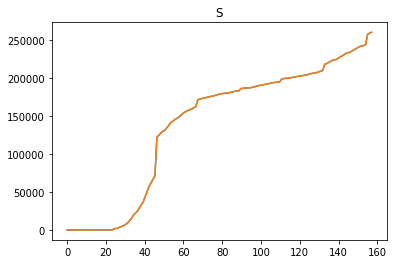

In [357]:
dat=np.linspace(0,len(St_pred)-1,len(St_pred)-1)
plt.plot(dat,St_pred[0:len(St_pred)-1])
plt.plot(dat,St[0:len(St)-1])
plt.title('S')

Text(0.5, 1.0, 'R')

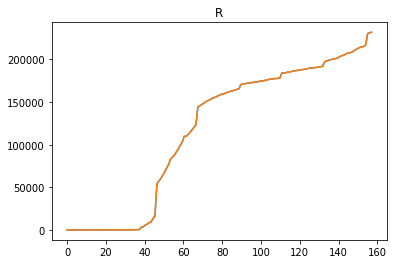

In [358]:
dat=np.linspace(0,len(Rt_pred)-1,len(Rt_pred)-1)
plt.plot(dat,Rt_pred[0:len(Rt_pred)-1])
plt.plot(dat,Rt[0:len(Rt)-1])
plt.title('R')